### Autor: Paula Domínguez Morales (855681)
### Fecha: 20 de Enero de 2025

---

<p style="text-align: center;">
    <img src="img/Uax_Logo.jpg" alt="Logo UAX" style="width: 40%;">
</p>

---

# Termofluidodinámica

## Estudio de una Caldera para Oxicombustión de Metano en Plantas de Cogeneración

---

### Introducción

Este notebook documenta la resolución de los requisitos establecidos para evaluar el diseño y el funcionamiento de una caldera basada en oxicombustión de metano. Este análisis abarca desde las condiciones iniciales de arranque hasta los modos estacionarios de operación. También se explorarán aspectos clave como la eficiencia térmica, la generación de contaminantes y los posibles ajustes en el diseño para optimizar su rendimiento.

El enunciado completo, con los detalles técnicos y los parámetros necesarios, se encuentra en el archivo adjunto dentro de la misma carpeta que este notebook. A continuación, se presenta un esquema de los puntos principales a resolver:

---

### Modelo de Arranque:
1. **Cálculo de la temperatura teórica del quemador** para diferentes dosados (φ) hasta alcanzar el régimen estequiométrico.
2. **Determinación de posibles cantidades de metano sin quemar** durante el arranque.
3. **Verificación de las condiciones necesarias para la ignición espontánea**, considerando alternativas para el arranque.
4. **Cálculo del área del cambiador de calor** para cumplir con los criterios de temperatura en el mezclador.
5. **Estimación del retraso máximo permitido** entre el inicio de la llama de premezcla y el cierre de la escotilla.

---

### Modos Estacionarios:
1. **Análisis de las configuraciones de funcionamiento**: 
   - *Modo A*: Condensador activado.
   - *Modo B*: Condensador desactivado.
2. **Evaluación de la cantidad de CH₄ y H₂O en recirculación** para cada modo.
3. **Cálculo de la cantidad de CO₂ recirculado** en cada configuración.
4. **Estudio de la longitud de la llama**, considerando si se desarrollan estructuras de Burke-Schumann.
5. **Impacto de los modos de funcionamiento en la operación**, incluyendo ventajas y desventajas entre las configuraciones A y B.

---

### Viabilidad y Limitaciones del Diseño:
Se discutirá la viabilidad de implementar este diseño de caldera para oxicombustión, evaluando aspectos como:

1. **La efectividad del condensador**.
2. **La idoneidad del metano como combustible**.
3. **La necesidad de redimensionar componentes clave**.
4. **Beneficios y limitaciones de los modos de operación propuestos**.

---

<p style="text-align: center;">
    <img src="img/Caldera.jpg" aldth: 70%;">
</div>

---


## Solución

#### Carga de librerías

In [310]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pyturb.gas_models.semiperfect_ideal_gas import SemiperfectIdealGas
from pyturb.combustion.combustion_thermodynamics import Combustion

aire = SemiperfectIdealGas('Air')
Maire = aire.Mg*1e-3

#### Datos y propiedades de gas:

In [311]:
o2 = SemiperfectIdealGas('O2')
co2 = SemiperfectIdealGas('CO2')
h2o = SemiperfectIdealGas('H2O')
ch4 = SemiperfectIdealGas('CH4')

MC = 12e-3 # kg/mol
MN = 14e-3 # kg/mol
MO = 16e-3 # kg/mol
MH = 1e-3 # kg/mol

MCO2 = MC + 2*MO
MH2O = 2*MH + MO
#MCH4 = MC + 4*MH
MO2 = 2*MO

#### Condiciones iniciales y de contorno

In [312]:
Tamb = 278.93 #K
T0 = Tamb
pamb = 101325 #Pa
P0 = pamb
#V = 0.45 #m^3
#Tmed = 750 #K
Rg = aire.Ru #8.314 J/K mol

#### Condiciones fracciones molares reales

In [313]:
#FACCIONES MOLARES
XCH4_r = 0.14470588
XCO2_r = 0.2647059
XH2O_r = 0.5294117
XO2_r = 1 - (XCH4_r+XCO2_r+XH2O_r)
phi_r = 1.4

#### Cinética química

In [314]:
A0 = 6e9 #(mol/cm3/s)**)(1-a-b)
a = -0.3
b = 1.3
EA = 30e3*4.184
#Ta = EA / Rg
Ta = EA*4184 / Rg

#### Combustible: Metano

In [315]:
ratio_equiv = 0.25
LHV_metano = 50.0205e6 #J/kg
HF_metano = 891e3 #J/mol
alpha = 1
beta = 4
gamma = 0
nFuel = 1

#### Datos Caldera

In [316]:
Tmax = 2500 #K
Da = 50
Vcaldera = 3.6e-3 #m3
Lcaldera = 0.2 #m
Acaldera = Vcaldera / Lcaldera
P0 = 101325 #Pa
P0_atm = P0*9.869e-6
Pmax = 10e6 #Pa
T0 = 273+25 #K
Q_cambiadorCalor = -27500 #W Calor disipado en el cambiador de calor
Q_ch4_0 = 4500 #cc/s CAUDAL
Q_co2_0 = Q_ch4_0 #CAUDAL
Ecorriente = 100000 #J #Energía turbina
h_caldera = 1 #W/(m2 K) #Factor de conveccion caldera
h_cambiadorCalor = 35 #W/(m2 K) #Factor de conveccion cambiadores de calor

In [317]:
def estequiometria_hc(alpha,beta,gamma,nFuel):
    """
    Calcula la estequiometría de una alcano asumiendo CnH2n+2Om donde n es el número de carbonos y m el de oxígenos presentes en el hidrocarburo.
    nFuel es la cantidad (mol) de combustible empleado. Si no se especifica se toma 1mol.
    """
 
    nCH4 = nFuel
    nO2 = (alpha+beta/4-gamma/2)
    #nN2 = nO2 * 79/21 
    nCO2 = alpha
    nH2O = beta/2
    
    #return nO2, nN2, nCO2, nH2O
    return nCH4, nO2, nCO2, nH2O

def dosado_estequiometrico(alpha, beta, gamma,nFuel):
    """
    Calcula el dosado estequiométrico de un HC.
    """

    nO2 = (alpha+beta/4-gamma/2)*nFuel
    #nN2 = nO2 * 79/21 
    #nCO2 = alpha*nFuel
    #nH2O = beta/2
    
    Mfuel = alpha*MC + beta*MH #kg/mol
    MComburente = nO2*(MO2)
    
    fs = Mfuel / MComburente
    
    return fs

## Cálculos iniciales:

La situación describe una oxicombustión de metano, por lo que el primer paso es determinar la mezcla estequiométrica de los gases involucrados. 

#### Parte estequiométrica de la reacción

In [318]:
nCH4_s, nO2_s, nCO2_s, nH2O_s = estequiometria_hc(alpha,beta,gamma,nFuel)

In [319]:
print('Condición estequiométrica:')
print('nO2_s={:6.3f}mol; nCO2_s={:6.3f}mol;  nH2O_s={:6.3f}mol'.format(nO2_s, nCO2_s, nH2O_s))

Condición estequiométrica:
nO2_s= 2.000mol; nCO2_s= 1.000mol;  nH2O_s= 2.000mol


#### Condiciones de dosado estequiométrico

In [320]:
f_s = dosado_estequiometrico(alpha,beta,gamma,nFuel)
print(f"Dosado Estequiométrico: {str(f_s)}")

Dosado Estequiométrico: 0.25


## Arranque

Al entender la reacción, podemos determinar las cantidades estequiométricas de reactivos y productos. Con esta información, es posible iniciar el análisis del problema y abordar sus detalles específicos. Procederemos comenzando con la puesta en marcha de la máquina, considerando las siguientes cuestiones planteadas.

1) ### La temperatura teórica de la caldera en el arranque si se hiciera un barrido de dosados de \(f = 0\) hasta \(\phi = 2\)

#### Procedimiento para una mezcla pobre:

Se han propuesto dos enfoques para determinar la temperatura teórica al usar una mezcla con un dosado inferior a la relación estequiométrica:

##### Primer enfoque:
- Se parte de introducirn mode \(CH_4\) en la caldera, junto con la cantidad de aire necesaria para alcanzar un dosado menor a 1.
- La única variable será la cantidad de oxígeno presente, tanto en los reactivos como en los productos. Los productos incluirán los gases generados en la reacción junto con el oxígeno excedente, calculado como el sobrante de una mezcla estequiométrica.
- El calor liberado será constante, ya que se quema exactame  un l de \(CH_4\). Este dependerá del caloretano del ((t_n)LHV_{CH_4}\)), de la  sa(mola)\(M_{CH_4}\)) y del número de moles.

##### Segundo enfoque:
En este método, se establece que la canad detano (\(CH_4\)) utilizada depende directamente del valor del dosado (\(\phi\)). Esto permite que tanto el metano como el oxígeno sean variables dentro del sistema.

 La ntidad de \(CH_4\) presente en los reactivos se calcula como el producto del dosado y el número de moles necesario para una proporción estequiométrica.

2. El oxígeno consumido durante la combustión se obtiene multiplandoos moles de \(CH_4\) por el coeficiente estequiométrico, que en este caso es 2.

3. La cantidad de oxígeno restante en los productos se calcula restando el oxígeno quemado al oxígeno estequiométrico total.

###### Energía liberada:
El calor generado en la combustión vaa sen la cantidad de \(CH_4\) utilizado, ya que depende de cuántos moles de combustible reaccionan.

Este procedimiento permite explorar diferentes valores del dosado y evaluar cómo afectan a la temperatura teórica en el sistema.

Se trata de un enfoque más robusto, ya que genera un análisis más uniforme de las temperaturas obtenidas y refleja con mayor precisión los efectos del dosado en el sistema.
en el sistema.


In [321]:
# Enfoque 1:

phi_pobre = np.linspace(0.1, 1, 10)  # Genera un rango de 10 valores de phi entre 0.1 y 1 (mezcla pobre)
print('phi mezcla pobre=', phi_pobre)  # Imprime los valores de phi para la mezcla pobre

# Para mezcla pobre

MCH4 = alpha*MC + beta*MH # Masa molar del metano en kg/mol
mfuel_s = nCH4_s*MCH4 # Masa del metano en kg

mCH4_pobre = mfuel_s  # La cantidad de combustible es igual a la cantidad estequiométrica
Qneto = 0.6 * (mCH4_pobre * LHV_metano)  # Calcula el calor neto liberado en la combustión considerando un 60% de eficiencia

nO2_pobre_p = nO2_s / phi_pobre - alpha - beta / 4  # Calcula el oxígeno sobrante en los productos de la reacción

Tad_pobre = (  # Calcula la temperatura adiabática de los productos
    T0 +  # Suma la temperatura inicial
    (Qneto) /  # Divide el calor neto entre la capacidad calorífica total de los productos
    (
        o2.cp_molar(T0) * nO2_pobre_p +  # Contribución del oxígeno al calor específico
        co2.cp_molar(T0) * nO2_s +  # Contribución del dióxido de carbono al calor específico
        h2o.cp_molar(T0) * nH2O_s  # Contribución del vapor de agua al calor específico
    )
)

print('Barrido de temperaturas en mezcla pobre [K]', Tad_pobre)  # Imprime las temperaturas calculadas para cada valor de phi


phi mezcla pobre= [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Barrido de temperaturas en mezcla pobre [K] [1014.4716376  1573.59278219 2022.07023374 2389.78966185 2696.762641
 2956.89346346 3180.14381404 3373.8376905  3543.48022044 3693.28928642]


In [322]:
# Enfoque 2: mejor aproximacion

phi_pobre = np.linspace(0.1, 1, 10)  # Genera un rango de 10 valores de phi entre 0.1 y 1 para la mezcla pobre
print('phi mezcla pobre=', phi_pobre)  # Imprime los valores de phi generados

# Para mezcla pobre
MCH4 = alpha*MC + beta*MH # Masa molar del metano en kg/mol
mfuel_s = nCH4_s*MCH4 # Masa del metano en kg

nCH4_pobre = phi_pobre * mfuel_s  # Calcula la cantidad de moles de CH4 en los reactivos para cada phi
mCH4_pobre = nCH4_pobre * MCH4  # Calcula la masa de combustible (metano) en función de los moles y su masa molar

Qneto = 0.6 * (mCH4_pobre * LHV_metano)  # Calcula el calor neto liberado en la combustión considerando un 60% de eficiencia

nO2_s_pobre = nCH4_pobre * (alpha + beta / 4)  # Calcula el oxígeno consumido en la combustión según la proporción estequiométrica
nO2_pobre_productos = nO2_s - nO2_s_pobre  # Calcula el oxígeno sobrante en los productos de la reacción

Tad_pobre = (  # Calcula la temperatura adiabática de los productos para cada phi
    T0 +  # Suma la temperatura inicial
    (Qneto) /  # Divide el calor neto liberado entre la capacidad calorífica total de los productos
    (
        o2.cp_molar(T0) * nO2_pobre_productos +  # Contribución del oxígeno al calor específico
        co2.cp_molar(T0) * nCO2_s +  # Contribución del dióxido de carbono al calor específico
        h2o.cp_molar(T0) * nH2O_s  # Contribución del vapor de agua al calor específico
    )
)
print("Barrido de temperaturas adiabaticas mezcla pobre [K]")
print(Tad_pobre)  # Imprime el resultado del barrido de temperaturas para la mezcla pobre


phi mezcla pobre= [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Barrido de temperaturas adiabaticas mezcla pobre [K]
[302.71466106 307.43476471 312.1603204  316.89133757 321.62782569
 326.36979426 331.1172528  335.87021085 340.62867796 345.39266373]


In [323]:
# Para mezcla rica

phi_rica = np.linspace(1.1, 2, 10)  # Genera un rango de 10 valores de phi entre 1.1 y 2 (mezcla rica)
print('phi mezcla rica=', phi_rica)  # Imprime los valores de phi para la mezcla rica

mcomburente_s = nO2_s*(MO*2) # kg/mol

nCH4_rica = phi_rica * f_s * mcomburente_s / mfuel_s  # Calcula los moles de CH4 presentes en la mezcla rica
nCH4_rica_productos = nCH4_rica - nCH4_s  # Calcula los moles de CH4 no quemados en los productos

Qneto = (0.6 * (mfuel_s * LHV_metano))  # Calcula el calor neto liberado en la combustión con un rendimiento del 60%

Tad_rica = (  # Calcula la temperatura adiabática de los productos para la mezcla rica
    T0 +  # Suma la temperatura inicial
    Qneto /  # Divide el calor neto liberado entre la capacidad calorífica total de los productos
    (
        ch4.cp_molar(T0) * nCH4_rica_productos +  # Contribución del metano no quemado al calor específico
        co2.cp_molar(T0) * nCO2_s +  # Contribución del dióxido de carbono al calor específico
        h2o.cp_molar(T0) * nH2O_s  # Contribución del vapor de agua al calor específico
    )
)

print('Barrido de temperaturas en mezcla rica [K]', Tad_rica)  # Imprime los valores calculados de la temperatura adiabática para cada phi


phi mezcla rica= [1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]
Barrido de temperaturas en mezcla rica [K] [4749.60222318 4607.05147603 4473.3470671  4347.69030672 4229.37584226
 4117.77841065 4012.34178492 3912.56950213 3818.01704667 3728.28522904]


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
[ 302.71466106  307.43476471  312.1603204   316.89133757  321.62782569
  326.36979426  331.1172528   335.87021085  340.62867796  345.39266373
 4749.60222318 4607.05147603 4473.3470671  4347.69030672 4229.37584226
 4117.77841065 4012.34178492 3912.56950213 3818.01704667 3728.28522904]


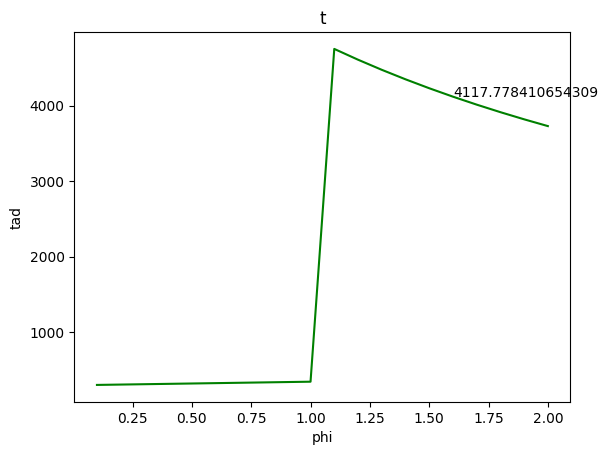

In [324]:
phi=np.concatenate((phi_pobre, phi_rica), axis=0)
Tad = np.concatenate((Tad_pobre, Tad_rica), axis=0)
print (phi)
print (Tad)
plt.plot(phi, Tad, color="green")
plt.title ( "t")
plt.xlabel("phi")
plt.ylabel("tad")

plt.annotate(str(Tad[15]), xy=(phi[15], Tad[15]))
plt.show() 

### 2) Si se quema todo el metano inyectado o si queda alguna cantidad sin quemar. En ese caso, calcular también la cantidad de metano inquemado, a pesar de la mezcla rica, en la llama de premezcla.

#### Contexto de la mezcla rica
En esta fase, la mezcla utilizada tiene un dosado phi = 1.4, lo que indica un exceso de combustible respecto a la cantidad estequiométrica de aire necesaria para una combustión completa. Este exceso genera condiciones donde el metano CH_4 podría no quemarse por completo.

#### Fracciones molares de los productos
Se determinan las fracciones molares de las especies presentes en los productos (\(CH_4\), \(CO_2\), \(H_2O\), \(O_2\)). En este caso, estas fracciones no suman 1, lo que indica que hay oxígeno residual en los productos. Esto implica que la combustión no es perfecta, dejando parte del combustible sin reaccionar.

#### Cálculo de los moles totales
La cantidad total de moles presentes en la caldera se calcula utilizando las condiciones iniciales del sistema (presión, volumen, constante de gases, y temperatura inicial). Este valor sirve como base para determinar los moles individuales de cada especie presente en los productos.

#### Determinación de los moles de las especies en los productos
Con las fracciones molares y los moles totales, se calculan los moles de cada especie en los productos (\(CH_4\), \(CO_2\), \(H_2O\), \(O_2\)). Estos valores permiten reconstruir la reacción química en función de las cantidades reales observadas en los productos.

#### Identificación del metano no quemado
El metano que no se ha quemado se calcula como la diferencia entre los moles de \(CH_4\) inyectados en los reactivos y los moles observados en los productos. Este valor es crucial para evaluar la eficiencia de la combustión y calcular el aporte energético real.

#### Oxígeno quemado
El oxígeno consumido durante la combustión se determina como la diferencia entre los moles iniciales en los reactivos y los moles residuales en los productos. Alternativamente, este valor también se puede calcular a partir de los moles de metano quemados y la relación estequiométrica correspondiente.

#### Moles totales quemados
Se calcula la suma de los moles de \(CH_4\) y \(O_2\) que reaccionaron. Este dato es importante para estimar la fracción molar de las especies involucradas en la reacción y establecer el balance energético.

#### Consideraciones energéticas
Dado que no todo el metano se quema, el aporte energético de la combustión debe calcularse únicamente con los moles de \(CH_4\) que realmente reaccionaro,n. Esto establece una base importante para las etapas posteriores del análisis.
<

In [325]:
f_r = phi_r * f_s  # Calcula el dosado real de la mezcla
print('dosado (phi=1.4)', f_r) 

n_total_s = P0 * Vcaldera / (Rg * T0)  # Moles totales estequiométricos en la caldera usando la ecuación de los gases ideales

n_total_CH4_s = n_total_s / (1 + (alpha + beta / 4))  # Moles de CH4 en los reactivos estequiométricos dividiendo los moles totales entre la suma de los coeficientes estequiométricos.
N_total_O2_s = n_total_s - n_total_CH4_s # Moles de O2 como la diferencia entre los moles totales y los de CH4

nO2_r = n_total_s / (f_r * (MO2 / MCH4) + 1)  # Moles de O2 en función del dosado real y las masas molares
nCH4_r = f_r * (MO2 / MCH4) * nO2_r  # Moles de CH4 en los reactivos a partir de los moles de O2 y el dosado real
n_total_r = nCH4_r + nO2_r  # Moles totales de los reactivos, es la suma los moles de CH4 y O2

n_total__productos_r = n_total_r  # Moles totales en los productos son iguales a los moles totales en los reactivos por conservación de la masa
nCH4_productos_r = n_total__productos_r * XCH4_r  # Moles de CH4 en los productos multiplicando los moles totales por la fracción molar de CH4
nCO2_productos_r = XCO2_r * n_total__productos_r  # Moles de CO2 en los productos
nH2O_productos_r = XH2O_r * n_total__productos_r  # Moles de H2O en los productos
nO2_productos_r = XO2_r * n_total__productos_r  # Moles de O2 en los productos

n_total__productos_r = nCH4_productos_r + nCO2_productos_r + nH2O_productos_r + nO2_productos_r  # Recalcula los moles totales en los productos como la suma de los moles de todas las especies.
print(f'Moles Totales en los reactantes = %-6.4f \nMoles Totales en los productos = %-6.4f'% (n_total_r, n_total__productos_r))  # Imprime los moles totales en los reactantes y productos para confirmar la conservación de la masa.


dosado (phi=1.4) 0.35
Moles Totales en los reactantes = 0.1472 
Moles Totales en los productos = 0.1472


In [326]:
print (f'Moles de CH4 reactantes = %-6.4f' %(nCH4_r))
print (f'Moles de O2 reactantes = %-6.4f' %(nO2_r))
   
print (f'Moles de CO2 productos = %-6.4f' %(nCO2_productos_r))
print (f'Moles de H2O productos = %-6.4f' %(nH2O_productos_r))

print (f'Moles de CH4 productos = %-6.4f' %(nCH4_productos_r)) 
print (f'Moles de O2 productos = %-6.4f' %(nO2_productos_r))

XCH4_reactantes_r = nCH4_r/n_total_r
print (f'Fracción molar CH4 reactante =%-6.4f'%XCH4_reactantes_r)
XO2_reactantes_r = nO2_r/n_total_r
print (f'Fracción molar O2 reactante =%-6.4f'%XO2_reactantes_r)

Moles de CH4 reactantes = 0.0606
Moles de O2 reactantes = 0.0866
Moles de CO2 productos = 0.0390
Moles de H2O productos = 0.0779
Moles de CH4 productos = 0.0213
Moles de O2 productos = 0.0090
Fracción molar CH4 reactante =0.4118
Fracción molar O2 reactante =0.5882


In [327]:
# Moles quemados

nO2_quemados = nO2_r - nO2_productos_r  # Moles de O2 quemados como la diferencia entre los moles iniciales en los reactivos y los moles restantes en los productos
print(f'Moles quemados de O2 = %-6.4f' % nO2_quemados)  # Moles de O2 que participaron en la combustión

nCH4_quemados = nCH4_r - nCH4_productos_r  # Moles de CH4 quemados como la diferencia entre los moles iniciales en los reactivos y los moles restantes en los productos
print(f'Moles quemados de CH4 = %-6.4f' % nCH4_quemados) 

nreactivos_quemados = nCH4_quemados + nO2_quemados  # Moles de CH4 y O2 quemados para obtener los moles totales que reaccionaron
print(f'Moles totales quemados = %-6.4f' % nreactivos_quemados)  

# Fracciones molares de lo quemado:
XCH4_quemados = nCH4_quemados / nreactivos_quemados  # Fracción molar de CH4 quemado dividiendo los moles de CH4 quemados entre los moles totales quemados
XO2_quemados = nO2_quemados / nreactivos_quemados  # Fracción molar de O2 quemado dividiendo los moles de O2 quemados entre los moles totales quemados

print(f'Fracción molar CH4 quemado = %-6.4f' % XCH4_quemados)  
print(f'Fracción molar de O2 quemado = %-6.4f' % XO2_quemados)  


Moles quemados de O2 = 0.0776
Moles quemados de CH4 = 0.0393
Moles totales quemados = 0.1169
Fracción molar CH4 quemado = 0.3363
Fracción molar de O2 quemado = 0.6637


### 3) Comprobar que la temperatura y la presión del recinto del quemador son suficientes para que se genere una llama de difusión sin necesidad de pilotar la ignición. En caso de no ser suficiente, calcular la presión de la caldera inicial (presión de metano y oxígeno) que debería haber para cumplir con la condición de encendido espontáneo. Para estimar la condición de autoignición se puede asumir que la temperatura de la pared durante la operación de la caldera es igual a la temperatura de pared calculada durante el arranque. .Se podría proporcionar un ratio de quemado inicial diferente a ϕ = 1,4 y que permita igualmente iniciar la mezcla en modo llama de difusión?

In [328]:
Qcombustion_quemador = nCH4_quemados * HF_metano  # Calor total liberado por la combustión del metano quemado, usando su entalpía de formación

Qneto_quemador = Qcombustion_quemador * 0.6  # Determina el calor neto disponible, considerando un 60% de eficiencia en el quemador

Qdisip_quemador = Qcombustion_quemador * 0.4  # Calcula la cantidad de calor disipado, que corresponde al 40% del total generado

Tpared_quemador = T0 + (3.6e-4 * (Qdisip_quemador / (h_caldera * Acaldera)))  # Temperatura de la pared del quemador en función del calor disipado, 
# usando el coeficiente de transferencia de calor de la caldera (h_caldera) y su área (Acaldera).

Tc_quemador = (Ta - np.sqrt(Ta**2 - 4 * Ta * Tpared_quemador)) / 2  # Temperatura crítica (Tc_q) usando una relación cuadrática  que depende de la temperatura ambiente (Ta) y la temperatura de la pared del quemador.

# Comprobar que tiene sentido la Tad
Tad_quemador = Tpared_quemador + Qneto_quemador / (
    ch4.cp_molar(Tpared_quemador) * nCH4_productos_r +  # Contribución del CH4 al calor específico
    co2.cp_molar(Tpared_quemador) * nCO2_productos_r +  # Contribución del CO2 al calor específico
    h2o.cp_molar(Tpared_quemador) * nH2O_productos_r +  # Contribución del H2O al calor específico
    o2.cp_molar(Tpared_quemador) * nO2_productos_r      # Contribución del O2 al calor específico
) # Temperatura adiabática del quemador (Tad_quemador), sumando la temperatura de la pared y el calor neto disponible  dividido entre las capacidades caloríficas molar ponderadas de los productos a la temperatura de la pared

a = -0.3
b = 1.3
A0 = 8.3e5

EfectoConstanteGases  = Rg * Tc_quemador
RelacionEnergiaActivacion  = EA / ((a+b) * Rg * Tc_quemador)
ImpactoTransferenciaCalor = (h_caldera * Acaldera / Vcaldera) * (Rg * Tc_quemador**2 / EA)
TasaReaccion = Qneto_quemador * A0 * (XCH4_quemados**a) * (XO2_quemados**b)
FactorEstequiometrico = (1/(a+b))

#Pc_quemador =  EfectoConstanteGases * np.e**RelacionEnergiaActivacion/ ((a+b) * Rg * Tc_quemador) * (ImpactoTransferenciaCalor/TasaReaccion)**FactorEstequiometrico

Pc_quemador = EfectoConstanteGases * np.e**RelacionEnergiaActivacion * (ImpactoTransferenciaCalor/TasaReaccion)**FactorEstequiometrico

P_caldera = n_total_r*Rg*Tad_quemador/(Vcaldera)

In [329]:
print ('Qc = ', Qcombustion_quemador)
print ('Qdisip =', Qdisip_quemador)
print('Tpared =', Tpared_quemador)
print ('Tc =', Tc_quemador)
print ('Pc_quemador =', Pc_quemador)
print ('P_caldera =', P_caldera)
print('T adiabatica = ', Tad_quemador)

Qc =  35031.06198511739
Qdisip = 14012.424794046958
Tpared = 578.2484958809391
Tc = 578.2537896670401
Pc_quemador = 8170719.433561254
P_caldera = 1384524.7070959536
T adiabatica =  4071.930547392985


## Condición de autoignición

En este caso, se observa que:

**Presión de la caldera < Presión crítica en el quemador**

Esto indica que la presión en la caldera no es suficiente para alcanzar la condición de autoignición. Para garantizar que esta condición se cumpla, es necesario que la presión de la caldera sea al menos igual a la presión crítica Pc_quemador. 

Para lograrlo, se plantean dos posibles estrategias:
1. Incrementar la temperatura de la pared.
2. Ajustar el dosado de la mezcla.

Para ello, modificamos el ratio para poder aumentar el dosado estequiométrico. Aumentandolo de 1.4 a 1.8.

Debemos iterar el ratio hasta que: **Presión de la caldera > Presión crítica en el quemador**


In [330]:
print("phi_r inicial: ",phi_r)
while P_caldera < Pc_quemador:
    

    f_r = phi_r * f_s  # Calcula el dosado real de la mezcla
    print(f"dosado (phi={str(phi_r)}) {str(f_r)}") 

    n_total_s = P0 * Vcaldera / (Rg * T0)  # Moles totales estequiométricos en la caldera usando la ecuación de los gases ideales

    n_total_CH4_s = n_total_s / (1 + (alpha + beta / 4))  # Moles de CH4 en los reactivos estequiométricos dividiendo los moles totales entre la suma de los coeficientes estequiométricos.
    N_total_O2_s = n_total_s - n_total_CH4_s # Moles de O2 como la diferencia entre los moles totales y los de CH4

    nO2_r = n_total_s / (f_r * (MO2 / MCH4) + 1)  # Moles de O2 en función del dosado real y las masas molares
    nCH4_r = f_r * (MO2 / MCH4) * nO2_r  # Moles de CH4 en los reactivos a partir de los moles de O2 y el dosado real
    n_total_r = nCH4_r + nO2_r  # Moles totales de los reactivos, es la suma los moles de CH4 y O2

    n_total__productos_r = n_total_r  # Moles totales en los productos son iguales a los moles totales en los reactivos por conservación de la masa
    nCH4_productos_r = n_total__productos_r * XCH4_r  # Moles de CH4 en los productos multiplicando los moles totales por la fracción molar de CH4
    nCO2_productos_r = XCO2_r * n_total__productos_r  # Moles de CO2 en los productos
    nH2O_productos_r = XH2O_r * n_total__productos_r  # Moles de H2O en los productos
    nO2_productos_r = XO2_r * n_total__productos_r  # Moles de O2 en los productos

    n_total__productos_r = nCH4_productos_r + nCO2_productos_r + nH2O_productos_r + nO2_productos_r  # Recalcula los moles totales en los productos como la suma de los moles de todas las especies.




    # Moles quemados con phi_r = 1.8 en vez de 1.4

    nO2_quemados = nO2_r - nO2_productos_r  # Moles de O2 quemados como la diferencia entre los moles iniciales en los reactivos y los moles restantes en los productos
    print(f'Moles quemados de O2 = %-6.4f' % nO2_quemados)  # Moles de O2 que participaron en la combustión

    nCH4_quemados = nCH4_r - nCH4_productos_r  # Moles de CH4 quemados como la diferencia entre los moles iniciales en los reactivos y los moles restantes en los productos
    print(f'Moles quemados de CH4 = %-6.4f' % nCH4_quemados) 

    nreactivos_quemados = nCH4_quemados + nO2_quemados  # Moles de CH4 y O2 quemados para obtener los moles totales que reaccionaron
    print(f'Moles totales quemados = %-6.4f' % nreactivos_quemados)  

    # Fracciones molares de lo quemado:
    XCH4_quemados = nCH4_quemados / nreactivos_quemados  # Fracción molar de CH4 quemado dividiendo los moles de CH4 quemados entre los moles totales quemados
    XO2_quemados = nO2_quemados / nreactivos_quemados  # Fracción molar de O2 quemado dividiendo los moles de O2 quemados entre los moles totales quemados

    print(f'Fracción molar CH4 quemado = %-6.4f' % XCH4_quemados)  
    print(f'Fracción molar de O2 quemado = %-6.4f' % XO2_quemados)  




    #Aumentando a phi_r = 1.8 en vez de 1.4

    Qcombustion_quemador = nCH4_quemados * HF_metano  # Calor total liberado por la combustión del metano quemado, usando su entalpía de formación

    Qneto_quemador = Qcombustion_quemador * 0.6  # Determina el calor neto disponible, considerando un 60% de eficiencia en el quemador

    Qdisip_quemador = Qcombustion_quemador * 0.4  # Calcula la cantidad de calor disipado, que corresponde al 40% del total generado

    Tpared_quemador = T0 + (3.6e-4 * (Qdisip_quemador / (h_caldera * Acaldera)))  # Temperatura de la pared del quemador en función del calor disipado, 
    # usando el coeficiente de transferencia de calor de la caldera (h_caldera) y su área (Acaldera).

    Tc_quemador = (Ta - np.sqrt(Ta**2 - 4 * Ta * Tpared_quemador)) / 2  # Temperatura crítica (Tc_q) usando una relación cuadrática  que depende de la temperatura ambiente (Ta) y la temperatura de la pared del quemador.

    # Comprobar que tiene sentido la Tad
    Tad_quemador = Tpared_quemador + Qneto_quemador / (
        ch4.cp_molar(Tpared_quemador) * nCH4_productos_r +  # Contribución del CH4 al calor específico
        co2.cp_molar(Tpared_quemador) * nCO2_productos_r +  # Contribución del CO2 al calor específico
        h2o.cp_molar(Tpared_quemador) * nH2O_productos_r +  # Contribución del H2O al calor específico
        o2.cp_molar(Tpared_quemador) * nO2_productos_r      # Contribución del O2 al calor específico
    ) # Temperatura adiabática del quemador (Tad_quemador), sumando la temperatura de la pared y el calor neto disponible  dividido entre las capacidades caloríficas molar ponderadas de los productos a la temperatura de la pared

    a = -0.3
    b = 1.3
    A0 = 8.3e5

    EfectoConstanteGases  = Rg * Tc_quemador
    RelacionEnergiaActivacion  = EA / ((a+b) * Rg * Tc_quemador)
    ImpactoTransferenciaCalor = (h_caldera * Acaldera / Vcaldera) * (Rg * Tc_quemador**2 / EA)
    TasaReaccion = Qneto_quemador * A0 * (XCH4_quemados**a) * (XO2_quemados**b)
    FactorEstequiometrico = (1/(a+b))

    Pc_quemador = EfectoConstanteGases * np.e**RelacionEnergiaActivacion * (ImpactoTransferenciaCalor/TasaReaccion)**FactorEstequiometrico

    P_caldera = n_total_r*Rg*Tad_quemador/(Vcaldera)
    print("Pc_quemador ", Pc_quemador)
    print("P_caldera ", P_caldera)
    phi_r += 0.1

Tad_final = Tad_quemador
Tpared_quemador_final = Tpared_quemador
P_caldera_final =P_caldera
Pc_quemador_final= Pc_quemador
Tc_quemador_final = Tc_quemador
nCH4_quemados_final = nCH4_quemados
nO2_quemados_final = nO2_quemados
ntotal_quemados_final = n_total__productos_r
nCH4_reactantes_final = nCH4_r
nO2_reactantes_final = nO2_productos_r
nreactivos_quemados_final = nreactivos_quemados

NrT = 1
Xr_ch4 = 1
Xr_o2 = 1
phi_1 = phi_r

Tad_1 = Tad_quemador
T_pared_1 = Tpared_quemador_final
Tc_1 = Tc_quemador_final
Pc_1 = Pc_quemador_final
P_caldera_1 = P_caldera_final
Nq_ch4_1 = nCH4_quemados_final
Nq_o2_1 = nO2_quemados_final
NqT_1 = ntotal_quemados_final 
Nr_ch4_1 = nCH4_reactantes_final
Nr_o2_1 = nO2_reactantes_final
NrT_1 = NrT
Xr_ch4_1 = Xr_ch4
Xr_o2_1 = Xr_o2


print("phi_r final: ",phi_r)

phi_r inicial:  1.4
dosado (phi=1.4) 0.35
Moles quemados de O2 = 0.0776
Moles quemados de CH4 = 0.0393
Moles totales quemados = 0.1169
Fracción molar CH4 quemado = 0.3363
Fracción molar de O2 quemado = 0.6637
Pc_quemador  8170719.433561254
P_caldera  1384524.7070959536
dosado (phi=1.5) 0.375
Moles quemados de O2 = 0.0751
Moles quemados de CH4 = 0.0418
Moles totales quemados = 0.1169
Fracción molar CH4 quemado = 0.3575
Fracción molar de O2 quemado = 0.6425
Pc_quemador  4126297.441874651
P_caldera  1453416.0134449
dosado (phi=1.6) 0.4
Moles quemados de O2 = 0.0728
Moles quemados de CH4 = 0.0441
Moles totales quemados = 0.1169
Fracción molar CH4 quemado = 0.3774
Fracción molar de O2 quemado = 0.6226
Pc_quemador  2257268.342093125
P_caldera  1517518.931736832
dosado (phi=1.7000000000000002) 0.42500000000000004
Moles quemados de O2 = 0.0706
Moles quemados de CH4 = 0.0463
Moles totales quemados = 0.1169
Fracción molar CH4 quemado = 0.3964
Fracción molar de O2 quemado = 0.6036
Pc_quemador  13

### Solución

En este caso sí cumplimos la condición de:

**Presión de la caldera < Presión crítica en el quemador**

### 4) Calcular el área del cambiador de calor para que se cumpla el criterio de temperaturas en el mezclador

In [331]:
Acc = Q_cambiadorCalor/(h_cambiadorCalor*(Tpared_quemador_final - Tad_final))
print("Q_cambiadorCalor= "  ,Q_cambiadorCalor)
print("h_cambiadorCalor= "  ,h_cambiadorCalor)
print("Tpared_quemador_final= "  ,Tpared_quemador_final)
print("Tad_final= "  ,Tad_final)
print (f'Area del Cambiador de Calor = '+ str(Acc))

Q_cambiadorCalor=  -27500
h_cambiadorCalor=  35
Tpared_quemador_final=  628.2988280773536
Tad_final=  4638.9958277208325
Area del Cambiador de Calor = 0.19590467337326398


### 5) El retraso máximo que puede producirse entre la bujía (inicio de la  llama de premezcla) y el cierre de la escotilla (8) si se quiere que no escapen productos al ambiente

In [332]:
# Apartado 5
c0_ch4 = -9.1780e-3
c1_ch4 = 1.5964e-4
c2_ch4 = -3.4571e-8
c3_ch4 = 2.0839e-12
k_ch4 = c0_ch4 + c1_ch4*T0 + c2_ch4*T0**2 + c3_ch4*T0**3

c0_o2 = 5.9101e-4
c1_o2 = 1.0460e-4
c2_o2 = -3.7985e-8
c3_o2 = 7.372e-12
k_o2 = c0_o2 + c1_o2*T0 + c2_o2*T0**2 + c3_o2*T0**3

k_med = (k_ch4*Nr_ch4_1+k_o2*Nr_o2_1)/NrT_1
rho = P0/(T0*287)
cp_med =  ch4.cp_molar(T0)*(Xr_ch4_1/MCH4)+o2.cp_molar(T0)*(Xr_o2_1/MO2)
alpha_c = k_med/(cp_med*rho)

T_med = (Tad_1+T_pared_1)/2
rf = A0 * np.exp(-EA/(1600*Rg)) * Xr_ch4_1**a * Xr_o2_1**b * (P0*0.001/(1600*Rg))**(a+b)
tq = ((Xr_ch4_1*P0*0.001/(Rg*T0)))*0.001/rf

Sl = np.sqrt((alpha_c*(Tad_1-Tc_1))/(tq*(Tc_1-T0)))

t = Lcaldera/Sl

print (f'Velocida de la reacción =%2.4f'%rf)
print (f'Tiempo de reacción es =%2.4ef'%tq)
print (f'Velocidad del frente de llama =%2.4f'%Sl)
print (f'Tiempo para cerrar la valvula = %2.4f'%t)


Velocida de la reacción =0.5048
Tiempo de reacción es =8.1013e-05f
Velocidad del frente de llama =0.3264
Tiempo para cerrar la valvula = 0.6128


#### Fracciones másicas y molares pedidas

In [15]:
frac_mol_Fuel = nFuel/nreactivos_quemados_final
frac_mol_O2 = nO2/nreactivos_quemados_final
frac_mol_N2 = nN2/nreactivos_quemados_final

mCO2 = nCO2*MCO2
mH2O = nH2O*MH2O
mN2 = nN2*(MN*2)
mO2prod = nO2_prod*(MO*2)

mprod = mCO2 + mH2O + mN2 + mO2prod

frac_mas_CO2 = mCO2 / mprod
frac_mas_H2O = mH2O / mprod
frac_mas_N2 = mN2 / mprod
frac_mas_O2prod = mO2prod / mprod

In [ ]:
print('Fracciones molares en reactantes:')
print('frac_molar_Fuel: {:6.4f};  frac_molar_O2: {:6.4f};  frac_masica_N2: {:6.4f}'.format(frac_mol_Fuel, frac_mol_O2, frac_mol_N2))
print('Suma fracciones: ', frac_mas_CO2+frac_mas_H2O+frac_mas_N2+frac_mas_O2prod)

In [ ]:
print('Fracciones másicas en productos:')
print('frac_masica_CO2: {:6.4f};  frac_masica_H2O: {:6.4f};  frac_masica_N2: {:6.4f};  frac_masica_O2: {:6.4f}'.format(frac_mas_CO2, frac_mas_H2O, frac_mas_N2, frac_mas_O2prod))
print('Suma fracciones: ', frac_mas_CO2+frac_mas_H2O+frac_mas_N2+frac_mas_O2prod)
frac_mas_CO2+frac_mas_H2O<10

#### Dosado real y estequiométrico

In [19]:
frac_mas_hept = (0.7*Mhept)/(0.7*Mhept+0.3*Mpent)
frac_mas_pent = (0.3*Mpent)/(0.7*Mhept+0.3*Mpent)

In [ ]:
fs = dosado_estequiometrico(7)*frac_mas_hept + dosado_estequiometrico(5)*frac_mas_pent
f = ratio_equiv*fs
print('f=',f)

#### Masa de productos asumida a aire

In [21]:
maire = mprod
naire = nprod

## Apartado 2:

Asumiendo que se tiene $1mol$ de combustible, calcule el calor de la combustión y la temperatura de llama. Para ello tome como temperatura promedio de la combustión 750K. Discuta la idoneidad de esta temperatura promedio.

#### Poder calorífico de combustible

In [22]:
LHVfuel = LHV_heptano*frac_mas_hept + LHV_pentano*frac_mas_pent

In [ ]:
print('LHVfuel = {:6.3f}MJ/kg'.format(LHVfuel*1e-6))

#### Temperatura adiabática de llama iterada

In [ ]:
sigue_iterando = True
Tmed = Tamb
iter_max = 100
tolerancia = 1e-6
niter = 0

while sigue_iterando:
    niter +=1
    Tmed_ = Tmed
    
    deltaTad = f*LHVfuel / ( (1+f)*aire.cp(Tmed) )
    
    Tad = Tamb + deltaTad
    Tmed = (Tad + Tamb)/2
    
    residuo = abs(Tmed-Tmed_)/Tmed_
    
    print('ii={};  Tmed={};  Tad={};  residuo={}'.format(niter, Tmed, Tad, residuo))
    
    if residuo<tolerancia:
        print('Solución obtenida')
        sigue_iterando = False
    elif niter>iter_max:
        print('Solución no convergida, iteraciones máximas excedidas')
        sigue_iterando = False


In [25]:
Tmed_ = 750 #K
deltaTad_ = f*LHVfuel / ( (1+f)*aire.cp(Tmed_) )
Tad_ = Tamb + deltaTad_
Tmed_ = 0.5*(Tad_+Tamb)

In [ ]:
print('Tad_={:7.1f}K'.format(Tad_))
print('Tmed_={:7.1f}K'.format(Tmed_))

La temperatura media propuesta es suficiente para caracterizar la mezcla de productos.

## Apartado 3

Calcule el tiempo característico para quemar $1mol$ de mezcla de combustible dadas las condiciones de presión y temperatura del combustor.

In [27]:
concentracionReact = (pamb/aire.Ru/Tamb) # mol/m^3
pre_exp = (A0*frac_mol_Fuel**a * frac_mol_O2**b * concentracionReact**(a+b))
exp = math.exp(-Ta/Tamb)

In [28]:
rf = pre_exp * exp
concentracionFuel = (pamb/aire.Ru/Tamb * frac_mol_Fuel)*1e-6
tau_q = concentracionFuel/rf

In [ ]:
print('rf={0:10.8f}mol/cm3/s'.format(rf))
print('tau_q={0:6.4}ms'.format(tau_q*1e3))

In [ ]:
concentracionFuel

## Apartado 4

Dado el resultado anterior discuta la idoneidad de la llama de premezcla para una turbina de gas. En caso de considerarla válida explique por qué, en caso contrario estudie el radio mínimo de inyección para tener una llama de difusión.

In [ ]:
nreactivos_quemados_final/(pamb/aire.Ru/Tamb)

In [ ]:
D0 = 2.475e3 # m^2/s
D = D0*math.exp(-Ta/Tmed)
print(D)

In [ ]:
math.sqrt(tau_q*D)